TypeError: unsupported operand type(s) for @: 'tuple' and 'array'

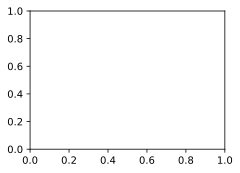

In [1]:
import mlx.core as mx
import mlx.nn as nn
from d2l import mlx as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)


def get_lstm_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return mx.random.normal(shape=shape)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                mx.zeros(num_hiddens))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = mx.zeros(num_outputs)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    return params

def init_lstm_state(batch_size, num_hiddens):
    return (mx.zeros((batch_size, num_hiddens)),
            mx.zeros((batch_size, num_hiddens)))

def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = mx.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = mx.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = mx.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = mx.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * mx.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return mx.concatenate(outputs, axis=0), (H, C)

vocab_size, num_hiddens = len(vocab), 256
num_epochs, lr = 500, 1
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs)